In [64]:

import os
import torch
import torch.nn.functional as F
import numpy as np
import sklearn.decomposition
from sklearn.linear_model import LinearRegression

from swag import data, models, utils, losses
from swag.posteriors import SWAG

import tqdm

from matplotlib import pyplot as plt
%matplotlib inline


In [2]:
torch.backends.cudnn.benchmark = True
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)

In [3]:
model_name = "PreResNet56"
model_cfg = getattr(models, model_name)
criterion = losses.cross_entropy

In [4]:
loaders, num_classes = data.loaders(
    "CIFAR100",
     "/home/wesley/Documents/datasets/",
#    "~/datasets",
    128,
    4,
    model_cfg.transform_train,
    model_cfg.transform_test,
    use_validation=False
)

Files already downloaded and verified
You are going to run models on the test set. Are you sure?
Files already downloaded and verified


In [5]:
model = model_cfg.base(*model_cfg.args, num_classes=num_classes, **model_cfg.kwargs)
model.cuda();

In [6]:
directory = "/home/wesley/Desktop/nfs01_tesla/swa_uncertainties/prn56_0120_rank"

In [7]:
def checkpoint_num(filename):
    num = filename.split("-")[1]
    num = num.split(".")[0]
    num = int(num)
    return num

In [8]:


pca_swag = SWAG(model_cfg.base, subspace_type='pca', subspace_kwargs={'max_rank':140, 'pca_rank':'mle'}, 
                *model_cfg.args, num_classes=num_classes, **model_cfg.kwargs)
pca_swag.cuda()


In [9]:

for file in os.listdir(directory):
    if "checkpoint" in file and checkpoint_num(file) > 160:
        path = os.path.join(directory, file)
        print('Loading %s' % path)
        checkpoint = torch.load(path)
        model.load_state_dict(checkpoint['state_dict'])
        pca_swag.collect_model(model)

Loading /home/wesley/Desktop/nfs01_tesla/swa_uncertainties/prn56_0120_rank/checkpoint-161.pt
Loading /home/wesley/Desktop/nfs01_tesla/swa_uncertainties/prn56_0120_rank/checkpoint-162.pt
Loading /home/wesley/Desktop/nfs01_tesla/swa_uncertainties/prn56_0120_rank/checkpoint-163.pt
Loading /home/wesley/Desktop/nfs01_tesla/swa_uncertainties/prn56_0120_rank/checkpoint-164.pt
Loading /home/wesley/Desktop/nfs01_tesla/swa_uncertainties/prn56_0120_rank/checkpoint-165.pt
Loading /home/wesley/Desktop/nfs01_tesla/swa_uncertainties/prn56_0120_rank/checkpoint-166.pt
Loading /home/wesley/Desktop/nfs01_tesla/swa_uncertainties/prn56_0120_rank/checkpoint-167.pt
Loading /home/wesley/Desktop/nfs01_tesla/swa_uncertainties/prn56_0120_rank/checkpoint-168.pt
Loading /home/wesley/Desktop/nfs01_tesla/swa_uncertainties/prn56_0120_rank/checkpoint-169.pt
Loading /home/wesley/Desktop/nfs01_tesla/swa_uncertainties/prn56_0120_rank/checkpoint-170.pt
Loading /home/wesley/Desktop/nfs01_tesla/swa_uncertainties/prn56_0120_

Loading /home/wesley/Desktop/nfs01_tesla/swa_uncertainties/prn56_0120_rank/checkpoint-250.pt
Loading /home/wesley/Desktop/nfs01_tesla/swa_uncertainties/prn56_0120_rank/checkpoint-251.pt
Loading /home/wesley/Desktop/nfs01_tesla/swa_uncertainties/prn56_0120_rank/checkpoint-252.pt
Loading /home/wesley/Desktop/nfs01_tesla/swa_uncertainties/prn56_0120_rank/checkpoint-253.pt
Loading /home/wesley/Desktop/nfs01_tesla/swa_uncertainties/prn56_0120_rank/checkpoint-254.pt
Loading /home/wesley/Desktop/nfs01_tesla/swa_uncertainties/prn56_0120_rank/checkpoint-255.pt
Loading /home/wesley/Desktop/nfs01_tesla/swa_uncertainties/prn56_0120_rank/checkpoint-256.pt
Loading /home/wesley/Desktop/nfs01_tesla/swa_uncertainties/prn56_0120_rank/checkpoint-257.pt
Loading /home/wesley/Desktop/nfs01_tesla/swa_uncertainties/prn56_0120_rank/checkpoint-258.pt
Loading /home/wesley/Desktop/nfs01_tesla/swa_uncertainties/prn56_0120_rank/checkpoint-259.pt
Loading /home/wesley/Desktop/nfs01_tesla/swa_uncertainties/prn56_0120_

In [ ]:
mean, var, cov = pca_swag.get_space()

In [11]:
utils.save_checkpoint(dir='/home/izmailovpavel/Desktop/nfs01_tesla/swa_uncertainties/prn56_0120_rank/',
                      name='pca-swag_new',
                    epoch=325, 
                     state_dict=pca_swag.state_dict())

In [ ]:
cov.shape

In [10]:
cov_mat = pca_swag.subspace.cov_mat_sqrt.clone().numpy()

In [11]:
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition.pca import _infer_dimension_, _assess_dimension_

In [12]:
decomp = TruncatedSVD(pca_swag.subspace.rank)

In [13]:
decomp.fit(cov_mat)

TruncatedSVD(algorithm='randomized', n_components=tensor([140]), n_iter=5,
       random_state=None, tol=0.0)

In [14]:
eigs = decomp.singular_values_**2.0 / pca_swag.n_models.item()

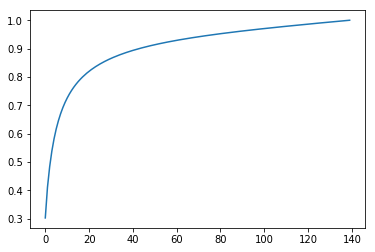

In [15]:
plt.plot(np.cumsum(eigs) / np.sum(eigs))

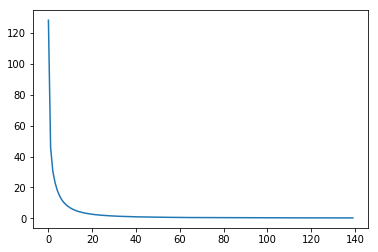

In [16]:
plt.plot(eigs)

In [17]:
cov_mat.shape[1]

613556

In [18]:
_infer_dimension_(eigs, n_features=140, n_samples=cov_mat.shape[1])

138

In [19]:
ll = np.zeros(len(eigs))
for i in range(len(eigs)):
    ll[i] = _assess_dimension_(spectrum=eigs, rank=i, n_samples=cov_mat.shape[1], n_features=cov_mat.shape[0])

In [20]:
decomp.components_.shape

(140, 613556)

In [21]:
np.log(cov_mat.shape[1])

13.327026818510982

In [55]:
rank_vec = np.arange(len(eigs))
m = (cov_mat.shape[1] * rank_vec - rank_vec * (rank_vec +1)/2)

correction = 0.5 * (m ) * np.log(pca_swag.n_models.item())

corrected_ll = ll - correction

In [58]:
from scipy.special import gammaln

In [61]:
n_features = cov_mat.shape[0]
pu = np.zeros_like(rank_vec)
for rank in rank_vec:
    pu[rank] = -rank * np.log(2.)
    for i in range(rank):
        pu[rank] += (gammaln((n_features - i) / 2.) -
               np.log(np.pi) * (n_features - i) / 2.)

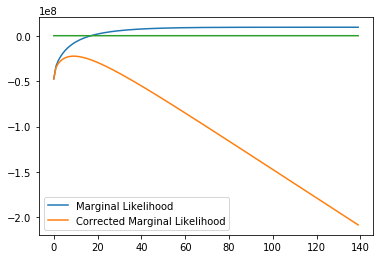

In [62]:
plt.plot(ll, label='Marginal Likelihood')
plt.plot(corrected_ll, label='Corrected Marginal Likelihood')
plt.legend()

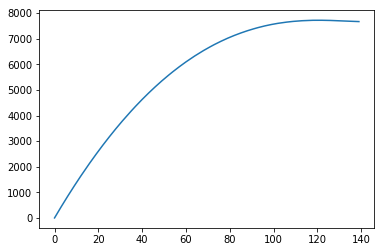

In [63]:
plt.plot(pu)


In [65]:
np.savez(file='/home/wesley/Documents/Papers/subspace_deeplearning/figs/data/prn56_marginal_likelihood.npz', 
         ll=ll, corrected_ll=corrected_ll,
        eigs=eigs)

In [ ]:
bic = -cov_mat.shape[1]/2 * eigs[:rank_vec]

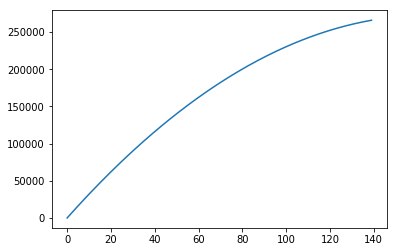

In [40]:
plt.plot(ll - corrected_ll)

In [13]:
fd_swag.fit()

In [14]:
from sklearn.decomposition.pca import _infer_dimension_

In [15]:
pca_swag.subspace.pca_decomp.n_features_

613556

In [16]:
_infer_dimension_(pca_bar, n_features=pca_swag.subspace.pca_decomp.n_features_, n_samples=pca_swag.subspace.pca_decomp.n_samples_)

139

In [17]:
ppca_swag.fit()
ppca_bar = ppca_swag.subspace.pca_decomp.explained_variance_ratio_

In [18]:
pca_swag.subspace.pca_rank

140

In [19]:
ppca_swag.subspace.pca_rank

138

<BarContainer object of 138 artists>

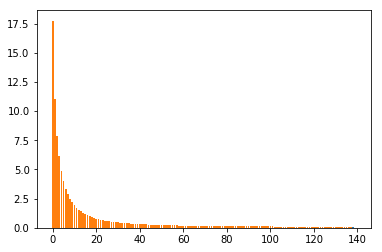

In [20]:
plt.bar(np.arange(len(pca_bar)), pca_bar * 100)
plt.bar(np.arange(len(ppca_bar)), ppca_bar * 100.)

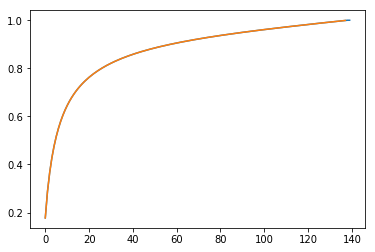

In [20]:
plt.plot(np.cumsum(pca_bar))
plt.plot(np.cumsum(ppca_bar))

In [43]:
utils.eval(loaders["test"], model, criterion)

{'accuracy': 98.95, 'loss': 0.03034447329044342}

In [44]:
def set_numpy(model_target, np_weights):
    offset = 0
    for param in model_target.parameters():
        size = np.prod(param.size())
        param.data = param.new_tensor(np_weights[offset:offset+size].reshape(param.size())).cuda()
        offset += size
        

def add_np_weights(model_target, model_source, np_dir, t):
    offset = 0
    for param_tmp, param in zip(model_target.parameters(), model_source.parameters()):
        size = np.prod(param.size())
        param_tmp.data.copy_(param.data)
#         print(param_tmp.data[0])
        param_tmp.data += t * param.new_tensor(np_dir[offset:offset+size].reshape(param.size())).cuda()
#         print(param_tmp.data[0])
#         print(param.data[0])
#         print()
        offset += size
        
        
def dist(model1, model2):
    dist = 0
    for param_tmp, param in zip(model1.parameters(), model2.parameters()):
        dist += torch.norm(param_tmp - param)**2
    return torch.sqrt(dist)


In [45]:
def get_ray_np(model, direction, max_t=10, min_t=-10, num_t=11, n_data=50000):
    
    model_tmp = model_cfg.base(*model_cfg.args, num_classes=num_classes, **model_cfg.kwargs)
    model_tmp.cuda();
    
    te_accs = []
    te_losses = []
    tr_accs = []
    tr_losses = []
    ts = np.linspace(min_t, max_t, num_t)
    dists = []
    
    for t in tqdm.tqdm(ts):
        add_np_weights(model_tmp, model, direction, t)
        test_res = utils.eval(loaders["test"], model_tmp, criterion)
        train_res = utils.eval(loaders["train"], model_tmp, criterion)
        te_accs.append(test_res["accuracy"])
        te_losses.append(test_res["loss"] * n_data)
        tr_accs.append(train_res["accuracy"])
        tr_losses.append(train_res["loss"] * n_data)
        dists.append(dist(model, model_tmp) * np.sign(t))
    
    return te_accs, te_losses, tr_accs, tr_losses, ts, dists

In [46]:
def fit_quadratic(train_losses, dists):
    y = np.array(train_losses)
    y -= y[y.size // 2]
    X = np.array(dists)[:, None]
    X = X**2
    linreg = LinearRegression(fit_intercept=False)
    linreg.fit(X, y)
    coef = linreg.coef_[0]
    var = 1 / (2 * coef)
    return var

In [47]:
model_swa = model_cfg.base(*model_cfg.args, num_classes=num_classes, **model_cfg.kwargs)
model_swa.cuda();
set_numpy(model_swa, pca.mean_)
utils.eval(loaders["test"], model_swa, criterion)

{'accuracy': 99.00999999999999, 'loss': 0.02942148087024689}

### Component 1

100%|██████████| 31/31 [01:13<00:00,  2.37s/it]

0.04728509839632115


Text(0.5, 0, 'Distance')

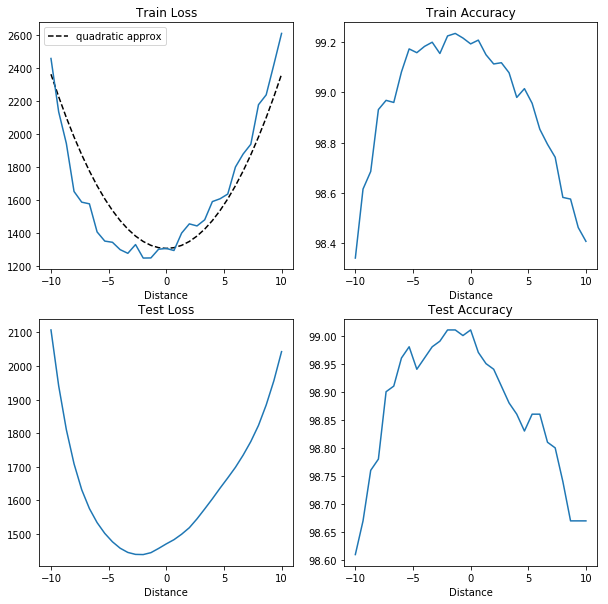

In [27]:
te_accs, te_losses, tr_accs, tr_losses, ts, dists = get_ray_np(model_swa, pca.components_[0], num_t=31)
var = fit_quadratic(tr_losses, dists)
print(var)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].plot(dists, 1 / (2 * var) * np.array(dists)**2 + tr_losses[len(tr_losses) // 2], "--k", label="quadratic approx")
ax[0, 0].plot(dists, tr_losses)
ax[0, 0].set_title("Train Loss")
ax[0, 0].set_xlabel("Distance")
ax[0, 0].legend()

ax[0, 1].plot(dists, tr_accs)
ax[0, 1].set_title("Train Accuracy")
ax[0, 1].set_xlabel("Distance")

ax[1, 0].plot(dists, te_losses)
ax[1, 0].set_title("Test Loss")
ax[1, 0].set_xlabel("Distance")

ax[1, 1].plot(dists, te_accs)
ax[1, 1].set_title("Test Accuracy")
ax[1, 1].set_xlabel("Distance")

### Component 2

100%|██████████| 31/31 [01:13<00:00,  2.36s/it]

0.00563635715219719


Text(0.5, 0, 'Distance')

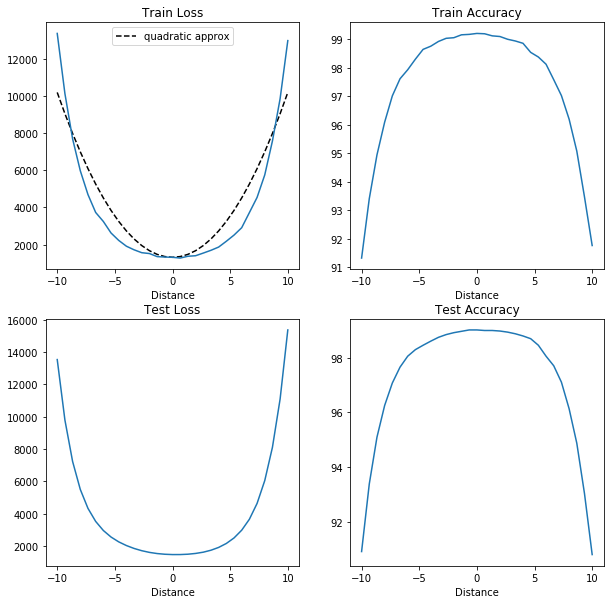

In [28]:
te_accs, te_losses, tr_accs, tr_losses, ts, dists = get_ray_np(model_swa, pca.components_[1], num_t=31)
var = fit_quadratic(tr_losses, dists)
print(var)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].plot(dists, 1 / (2 * var) * np.array(dists)**2 + tr_losses[len(tr_losses) // 2], "--k", label="quadratic approx")
ax[0, 0].plot(dists, tr_losses)
ax[0, 0].set_title("Train Loss")
ax[0, 0].set_xlabel("Distance")
ax[0, 0].legend()

ax[0, 1].plot(dists, tr_accs)
ax[0, 1].set_title("Train Accuracy")
ax[0, 1].set_xlabel("Distance")

ax[1, 0].plot(dists, te_losses)
ax[1, 0].set_title("Test Loss")
ax[1, 0].set_xlabel("Distance")

ax[1, 1].plot(dists, te_accs)
ax[1, 1].set_title("Test Accuracy")
ax[1, 1].set_xlabel("Distance")

### Component 3

100%|██████████| 31/31 [01:13<00:00,  2.39s/it]

0.0013753459746365852


Text(0.5, 0, 'Distance')

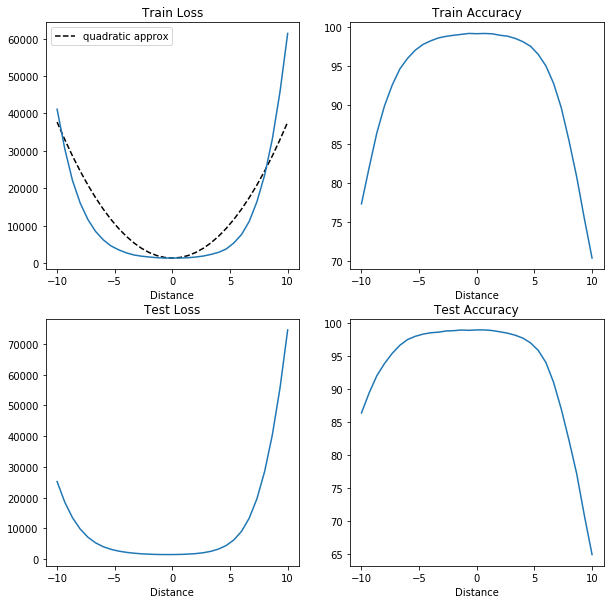

In [29]:
te_accs, te_losses, tr_accs, tr_losses, ts, dists = get_ray_np(model_swa, pca.components_[2], num_t=31)
var = fit_quadratic(tr_losses, dists)
print(var)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].plot(dists, 1 / (2 * var) * np.array(dists)**2 + tr_losses[len(tr_losses) // 2], "--k", label="quadratic approx")
ax[0, 0].plot(dists, tr_losses)
ax[0, 0].set_title("Train Loss")
ax[0, 0].set_xlabel("Distance")
ax[0, 0].legend()

ax[0, 1].plot(dists, tr_accs)
ax[0, 1].set_title("Train Accuracy")
ax[0, 1].set_xlabel("Distance")

ax[1, 0].plot(dists, te_losses)
ax[1, 0].set_title("Test Loss")
ax[1, 0].set_xlabel("Distance")

ax[1, 1].plot(dists, te_accs)
ax[1, 1].set_title("Test Accuracy")
ax[1, 1].set_xlabel("Distance")

### Component 4

100%|██████████| 31/31 [01:13<00:00,  2.38s/it]

0.00095046617346784


Text(0.5, 0, 'Distance')

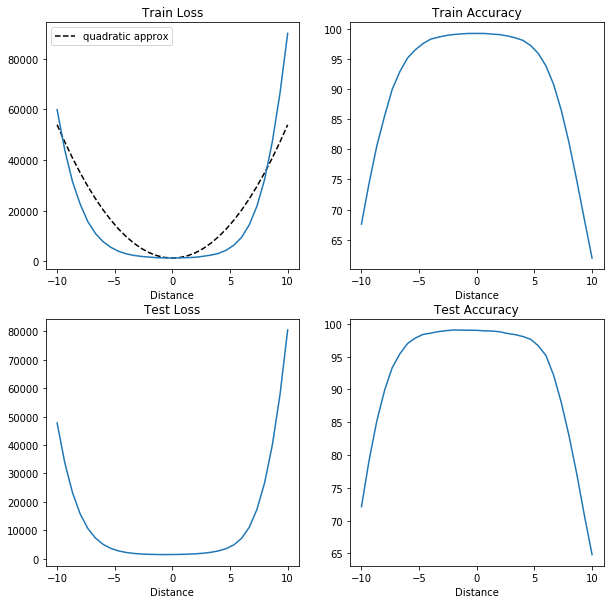

In [30]:
te_accs, te_losses, tr_accs, tr_losses, ts, dists = get_ray_np(model_swa, pca.components_[3], num_t=31)
var = fit_quadratic(tr_losses, dists)
print(var)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].plot(dists, 1 / (2 * var) * np.array(dists)**2 + tr_losses[len(tr_losses) // 2], "--k", label="quadratic approx")
ax[0, 0].plot(dists, tr_losses)
ax[0, 0].set_title("Train Loss")
ax[0, 0].set_xlabel("Distance")
ax[0, 0].legend()

ax[0, 1].plot(dists, tr_accs)
ax[0, 1].set_title("Train Accuracy")
ax[0, 1].set_xlabel("Distance")

ax[1, 0].plot(dists, te_losses)
ax[1, 0].set_title("Test Loss")
ax[1, 0].set_xlabel("Distance")

ax[1, 1].plot(dists, te_accs)
ax[1, 1].set_title("Test Accuracy")
ax[1, 1].set_xlabel("Distance")

## Ensembling

In [31]:
def nll(outputs, labels):
    labels = labels.astype(int)
    idx = (np.arange(labels.size), labels)
    ps = outputs[idx]
    nll = -np.sum(np.log(ps))
    return nll

def accuracy(outputs, labels):
    return np.mean(np.argmax(outputs, axis=1) == labels)

is the scale in our posterior approximation defined in any principled way?

In [32]:
n_samples = 30

# v1, v2, v3, v4 = 2188., 245., 57., 39.

v1, v2, v3, v4 = 0.047, 0.005, 0.001, 0.001

scale = 1.
v1 *= scale
v2 *= scale
v3 *= scale
v4 *= scale

ens_preds = np.zeros((10000, 10))

for i in range(n_samples):
    
    d1 = np.random.normal(scale=np.sqrt(v1))
    d2 = np.random.normal(scale=np.sqrt(v2))
    d3 = np.random.normal(scale=np.sqrt(v3))
    d4 = np.random.normal(scale=np.sqrt(v4))
    set_numpy(model, pca.mean_)
    add_np_weights(model, model, pca.components_[0], d1)
    add_np_weights(model, model, pca.components_[1], d2)
    add_np_weights(model, model, pca.components_[2], d3)
    add_np_weights(model, model, pca.components_[3], d4)
#     utils.eval(loaders["test"], model, criterion)
    preds, targets = utils.predictions(loaders["test"], model)
    ens_preds += preds
    print("Accuracy:", accuracy(ens_preds, targets))
    print("NLL:", nll(ens_preds / (i+1), targets))

Accuracy: 0.9901
NLL: 295.2157437378302
Accuracy: 0.9902
NLL: 295.3967514656007
Accuracy: 0.9902
NLL: 294.98041344596294
Accuracy: 0.9902
NLL: 294.6957019766625
Accuracy: 0.9902
NLL: 294.63603103964954
Accuracy: 0.9902
NLL: 294.40646746702896
Accuracy: 0.9902
NLL: 294.45469121370746
Accuracy: 0.9902
NLL: 294.34509147971886
Accuracy: 0.9902
NLL: 294.2616932371832
Accuracy: 0.9902
NLL: 294.2052941227979
Accuracy: 0.9902
NLL: 294.24037304003446
Accuracy: 0.9902
NLL: 294.3100604199685
Accuracy: 0.9902
NLL: 294.2954954009877
Accuracy: 0.9902
NLL: 294.22795435365964
Accuracy: 0.9902
NLL: 294.2769708948493
Accuracy: 0.9902
NLL: 294.218143299512
Accuracy: 0.9902
NLL: 294.2835796448924
Accuracy: 0.9902
NLL: 294.34952470109005
Accuracy: 0.9902
NLL: 294.30922641946466
Accuracy: 0.9902
NLL: 294.2979018163576
Accuracy: 0.9902
NLL: 294.29489009273465
Accuracy: 0.9902
NLL: 294.29616334935105
Accuracy: 0.9902
NLL: 294.30050932696827
Accuracy: 0.9902
NLL: 294.29327597950805
Accuracy: 0.9902
NLL: 294.28

In [161]:
preds, targets = utils.predictions(loaders["test"], model)

In [162]:
targets

array([7, 2, 1, ..., 4, 5, 6])

In [188]:
checkpoint = torch.load("../ckpts/mnist/lenet5/run1/sgd/checkpoint-50.pt")
model.load_state_dict(checkpoint['state_dict'])
res = utils.predict(loaders["test"], model)
preds = res["predictions"]
targets = res["targets"]
print("Accuracy:", accuracy(preds, targets))
print("NLL:", nll(preds, targets))

Accuracy: 0.9902
NLL: 302.16257


## Diversity

check diversity of predictions in the region corresponding to loss <= const or accuracy >= const for different PCA directions

In [59]:
n_samples = 30

# v1, v2, v3, v4 = 2188., 245., 57., 39.

v1, v2, v3, v4 = 0.047, 0.005, 0.001, 0.001

scale = 1.

set_numpy(model, pca.mean_)
preds, targets = utils.predictions(loaders["test"], model)
add_np_weights(model, model, pca.components_[0], np.sqrt(v1.) * scale)
print(utils.eval(loaders["test"], model, criterion))
preds0, targets = utils.predictions(loaders["test"], model)

set_numpy(model, pca.mean_)
add_np_weights(model, model, pca.components_[1], np.sqrt(v2.) * scale)
print(utils.eval(loaders["test"], model, criterion))
preds1, targets = utils.predictions(loaders["test"], model)


SyntaxError: invalid syntax (<ipython-input-59-81cc88739fea>, line 11)

In [57]:
print(np.sum(np.argmax(preds, axis=1) != np.argmax(preds0, axis=1)))
print(np.sum(np.argmax(preds, axis=1) != np.argmax(preds1, axis=1)))

40
50
